## Univariate correlation analysis

We wanted to look at whether correlations between gene expression and mutation status are primarily driven by a strong correlation in a single cancer type, or by weak correlations across all cancer types. To make the analysis simpler, we'll just look at univariate correlations between the expression of a single gene and mutation status in a given driver.

More specifically, we want to identify genes that have a strong univariate pan-cancer correlation, and classify them (roughly) as one of the following:

* Driven mostly by a single cancer type (one cancer type with a large correlation f-statistic, others fairly small)
* Driven mostly by 2+ cancer types (two or more cancer types with large correlations)

In [1]:
import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.tcga_utilities as tu

%load_ext autoreload
%autoreload 2

In [2]:
gene = 'TP53'
mad_threshold = 100

### Load expression data and mutation label data

In [3]:
print('Loading gene label data...', file=sys.stderr)
genes_df = du.load_top_50()
sample_info_df = du.load_sample_info(verbose=True)

# this returns a tuple of dataframes, unpack it below
pancancer_data = du.load_pancancer_data(verbose=True)
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

rnaseq_df = du.load_expression_data(verbose=True)

# standardize columns of expression dataframe
print('Standardizing columns of expression data...', file=sys.stderr)
rnaseq_df[rnaseq_df.columns] = StandardScaler().fit_transform(rnaseq_df[rnaseq_df.columns])

Loading gene label data...
Loading sample info...
Loading pan-cancer data from cached pickle file...
Loading gene expression data...
Standardizing columns of expression data...


In [4]:
print(rnaseq_df.shape)
rnaseq_df.iloc[:5, :5]

(11060, 16148)


,1,10,100,1000,10000
sample_id,,,,,
TCGA-02-0047-01,-0.144100,-0.136450,-0.207065,1.049402,0.644625
TCGA-02-0055-01,-0.124925,-0.197893,-0.132694,0.704438,0.154763
TCGA-02-2483-01,-0.133543,-0.174587,-0.103291,1.473420,0.669303
TCGA-02-2485-01,-0.147052,-0.072888,-0.213119,4.405612,11.503035
TCGA-02-2486-01,-0.145321,-0.181076,-0.147395,1.013468,0.117745


In [5]:
sample_freeze_df.head()

,PATIENT_BARCODE,SAMPLE_BARCODE,DISEASE,SUBTYPE
0,TCGA-OR-A5J1,TCGA-OR-A5J1-01,ACC,Not_Applicable
1,TCGA-OR-A5J2,TCGA-OR-A5J2-01,ACC,Not_Applicable
2,TCGA-OR-A5J3,TCGA-OR-A5J3-01,ACC,Not_Applicable
3,TCGA-OR-A5J5,TCGA-OR-A5J5-01,ACC,Not_Applicable
4,TCGA-OR-A5J6,TCGA-OR-A5J6-01,ACC,Not_Applicable


In [6]:
mutation_df.iloc[:5, :5]

,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [7]:
y_df = (mutation_df
    .loc[:, [gene]]
    .merge(sample_freeze_df, left_index=True, right_on='SAMPLE_BARCODE')
    .drop(columns='PATIENT_BARCODE')
    .set_index('SAMPLE_BARCODE')
    .rename(columns={gene: 'status',
                     'DISEASE': 'cancer_type',
                     'SUBTYPE': 'subtype'})
)
display(y_df.shape, y_df.head())

(9074, 3)

,status,cancer_type,subtype
SAMPLE_BARCODE,,,
TCGA-02-0047-01,0,GBM,IDHwt
TCGA-02-0055-01,1,GBM,IDHwt
TCGA-02-2483-01,1,GBM,IDHmut-non-codel
TCGA-02-2485-01,1,GBM,IDHwt
TCGA-02-2486-01,0,GBM,IDHwt


In [8]:
X_df = rnaseq_df.reindex(y_df.index)

# make sure we didn't introduce any NA rows
assert X_df.isna().sum().sum() == 0

display(X_df.shape,
        X_df.isna().sum().sum(),
        X_df.iloc[:5, :5])

(9074, 16148)

0

,1,10,100,1000,10000
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,-0.144100,-0.136450,-0.207065,1.049402,0.644625
TCGA-02-0055-01,-0.124925,-0.197893,-0.132694,0.704438,0.154763
TCGA-02-2483-01,-0.133543,-0.174587,-0.103291,1.473420,0.669303
TCGA-02-2485-01,-0.147052,-0.072888,-0.213119,4.405612,11.503035
TCGA-02-2486-01,-0.145321,-0.181076,-0.147395,1.013468,0.117745


### Subset genes by mean absolute deviation

In [9]:
# first subset by MAD
mad_genes_df = (rnaseq_df
    .mad(axis=0)
    .sort_values(ascending=False)
    .reset_index()
)
mad_genes_df.head()

,index,0
0,126695,0.821090
1,147798,0.808853
2,10053,0.808764
3,54845,0.803626
4,582,0.802497


In [10]:
mad_genes_df.columns=['gene_id', 'mad']
mad_genes = (mad_genes_df
  .head(mad_threshold)
  .gene_id
  .astype(str)
  .values
)

print(mad_genes[:5])

['126695' '147798' '10053' '54845' '582']


In [11]:
X_df = X_df.reindex(mad_genes, axis='columns')
display(X_df.shape, X_df.iloc[:5, :5])

(9074, 100)

,126695,147798,10053,54845,582
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,-1.307892,-0.977865,-1.119059,-1.116767,0.458711
TCGA-02-0055-01,-1.305820,-0.964695,-1.111900,-1.114346,-0.551517
TCGA-02-2483-01,-1.307892,-0.984642,-1.119059,-1.116851,-0.470321
TCGA-02-2485-01,-1.306134,-0.984678,-1.118344,-1.113535,1.100724
TCGA-02-2486-01,-1.305639,-0.983574,-1.119059,-1.117114,1.006310


### Calculate univariate feature correlations with mutation labels

In [12]:
from sklearn.feature_selection import f_classif, mutual_info_classif

f_stats_pancan = f_classif(X_df, y_df.status)[0]
display(f_stats_pancan[:10])

array([ 276.60698975,   70.28722435,   34.75394368,  753.51928171,
        744.36087967,  446.19287169, 1170.54889718,  168.5785283 ,
          5.27937846,  150.45691553])

In [13]:
def get_f_stats_for_cancer_types(X_df, y_df):
    f_stats_df = {}
    for cancer_type in y_df.cancer_type.unique():
        ct_samples = y_df[y_df.cancer_type == cancer_type].index
        X_ct_df = X_df.reindex(ct_samples)
        y_ct_df = y_df.reindex(ct_samples)
        
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                f_stats_df[cancer_type] = f_classif(X_ct_df, y_ct_df.status)[0]
            except RuntimeWarning:
                # this can happen if there are no mutated samples in the cancer type
                # in that case, just skip it
                continue
        
    return pd.DataFrame(f_stats_df, index=X_df.columns)

f_stats_df = get_f_stats_for_cancer_types(X_df, y_df)
f_stats_df['pancan'] = f_stats_pancan

# make sure we didn't introduce any NA rows
assert f_stats_df.isna().sum().sum() == 0

display(f_stats_df.shape,
        f_stats_df.isna().sum().sum(),
        f_stats_df.iloc[-5:, :5])

(100, 33)

0

,GBM,OV,LUAD,LUSC,PRAD
9341,2.723151,1.077021,0.078672,0.037524,0.089605
65982,0.047316,0.047248,19.764914,10.070783,5.333496
1656,10.898580,0.304855,0.053062,2.943339,2.253619
57573,0.073949,3.367391,9.698130,5.831784,5.983377
51652,0.508308,1.382821,23.220050,1.692238,0.182759


In [14]:
# get difference between max and min single-cancer f-statistic
max_df = f_stats_df.drop(columns='pancan').max(axis='columns')
min_df = f_stats_df.drop(columns='pancan').min(axis='columns')
min_max_df = (
    pd.DataFrame(max_df - min_df,
                 columns=['max - min'])
      .merge(f_stats_df.loc[:, ['pancan']],
             left_index=True, right_index=True)
)
min_max_df.sort_values(by='pancan', ascending=False).head(15)

,max - min,pancan
24137,290.781887,1215.285958
23397,302.217636,1170.548897
5347,351.053548,1124.041606
699,277.920176,1061.147200
9493,225.278353,923.233478
29127,128.586952,862.842986
55325,100.424225,823.754151
79172,279.389949,821.075427
146909,183.466143,807.072450
57659,299.319467,789.777604


### Calculate "outlier-ness" of correlation distributions

To partition genes with strong univariate correlations into "driven by a single cancer type" and "driven by two or more cancer types, we can use the [local outlier factor](https://en.wikipedia.org/wiki/Local_outlier_factor) of the cancer type with the maximum correlation.

A more negative LOF means the distribution is more "outlier-ish", and a LOF closer to 1 means the distribution is more uniform/less likely to contain an outlier.

In [15]:
from sklearn.neighbors import LocalOutlierFactor

lof_rows = []
for gene_id, row in f_stats_df.iterrows():
    row = row.drop(index='pancan')
    max_ix = row.idxmax()
    max_f_statistic = row.max()
    lof = LocalOutlierFactor(n_neighbors=2,
                             contamination='auto')
    lof.fit_predict(
        row.values.reshape(-1, 1)
    )
    max_lof = lof.negative_outlier_factor_[
        row.index.get_loc(max_ix)
    ]
    lof_rows.append([gene_id, max_ix, max_f_statistic, max_lof])
    
lof_df = (
    pd.DataFrame(lof_rows,
                 columns=['gene', 'max_cancer_type',
                          'max_f_statistic', 'max_lof'])
      .set_index('gene')
)
lof_df.head()

,max_cancer_type,max_f_statistic,max_lof
gene,,,
126695,STAD,26.357617,-43.547103
147798,BRCA,148.020744,-10.573249
10053,BRCA,24.230451,-2.920684
54845,BRCA,127.231395,-5.035958
582,BRCA,188.994801,-28.765280


In [16]:
rank_df = (min_max_df
    .merge(lof_df, left_index=True, right_index=True)
    .sort_values(by='pancan', ascending=False)
)

Text(0.5, 1.0, 'TP53 pan-cancer f-statistic vs. max individual LOF, per gene')

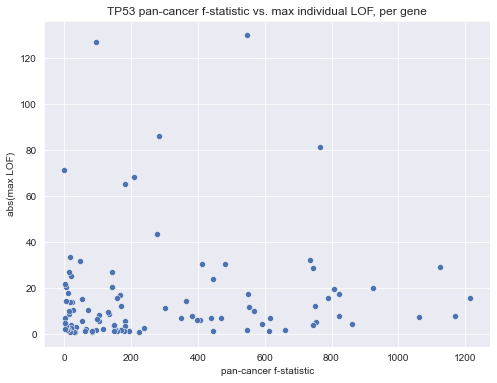

In [17]:
sns.set({'figure.figsize': (8, 6)})

rank_df['abs_max_lof'] = rank_df.max_lof.abs()

sns.scatterplot(data=rank_df, x='pancan', y='abs_max_lof')
plt.xlabel('pan-cancer f-statistic')
plt.ylabel('abs(max LOF)')
plt.title('{} pan-cancer f-statistic vs. max individual LOF, per gene'
            .format(gene))

Text(0.5, 1.0, 'TP53 max single-cancer f-statistic vs. max individual LOF, per gene')

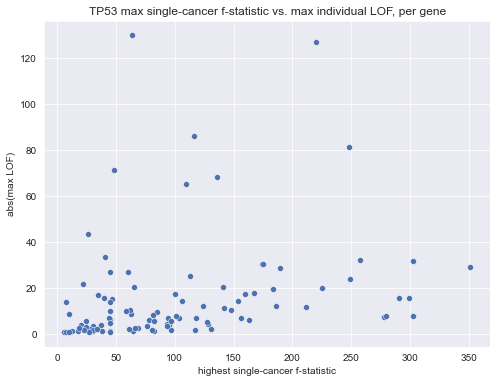

In [18]:
sns.set({'figure.figsize': (8, 6)})

sns.scatterplot(data=rank_df, x='max_f_statistic', y='abs_max_lof')
plt.xlabel('highest single-cancer f-statistic')
plt.ylabel('abs(max LOF)')
plt.title('{} max single-cancer f-statistic vs. max individual LOF, per gene'
          .format(gene))

In [19]:
# want to look at correlation of f-statistics with sample size
ss_df = (y_df
    .groupby('cancer_type')
    .count()
    .loc[:, ['subtype']]
    .rename(columns={'subtype': 'count'})
)

def plot_f_dist(plot_gene):
    dist_df = f_stats_df.loc[
        plot_gene, ~(f_stats_df.columns == 'pancan')
    ]
    f_ss_df = (f_stats_df
        .T
        .loc[f_stats_df.T.index != 'pancan', [plot_gene]]
        .rename(columns={plot_gene: 'f_statistic'})
        .merge(ss_df, left_index=True, right_index=True)
    )
    return dist_df, f_ss_df

In [20]:
sorted_genes = min_max_df.pancan.sort_values(ascending=False).index
display(sorted_genes[:10])

Index(['24137', '23397', '5347', '699', '9493', '29127', '55325', '79172',
       '146909', '57659'],
      dtype='object')

In [21]:
symbol_to_entrez, _ = tu.get_symbol_map()
entrez_to_symbol = {v: k for k, v in symbol_to_entrez.items()}
assert entrez_to_symbol[673] == 'BRAF'

In [22]:
rank_df['symbol'] = rank_df.index.to_series().astype(int).map(entrez_to_symbol)
rank_df.index.name = 'entrez_id'
rank_df = rank_df.reset_index().set_index('symbol', drop=False)
rank_df.head(20)

,entrez_id,max - min,pancan,max_cancer_type,max_f_statistic,max_lof,abs_max_lof,symbol
symbol,,,,,,,,
KIF4A,24137,290.781887,1215.285958,BRCA,290.782276,-15.805231,15.805231,KIF4A
NCAPH,23397,302.217636,1170.548897,BRCA,302.217668,-7.904053,7.904053,NCAPH
PLK1,5347,351.053548,1124.041606,BRCA,351.056898,-28.995296,28.995296,PLK1
BUB1,699,277.920176,1061.147200,BRCA,277.925279,-7.312019,7.312019,BUB1
KIF23,9493,225.278353,923.233478,BRCA,225.280224,-19.845620,19.845620,KIF23
RACGAP1,29127,128.586952,862.842986,BRCA,128.612580,-4.382810,4.382810,RACGAP1
UFSP2,55325,100.424225,823.754151,BRCA,100.424832,-17.404699,17.404699,UFSP2
CENPO,79172,279.389949,821.075427,BRCA,279.403738,-7.746309,7.746309,CENPO
KIF18B,146909,183.466143,807.072450,BRCA,183.467642,-19.750423,19.750423,KIF18B


In [23]:
# this is an example of a fairly skewed distribution
# (the cancer type with the top f-statistic, BRCA, has a large LOF)
plot_gene = sorted_genes[2]
dist_df, f_ss_df = plot_f_dist(plot_gene)
f_ss_df.sort_values(by='f_statistic', ascending=False).head(10)

,f_statistic,count
BRCA,351.056898,981
UCEC,72.698743,507
LIHC,57.952473,348
LUAD,55.548095,502
BLCA,49.620312,398
ACC,36.862054,76
KIRC,34.460291,352
STAD,23.312115,383
GBM,15.623279,119
PRAD,15.503404,479


Text(0.5, 1.0, 'Sample count vs. f-statistic, per cancer type')

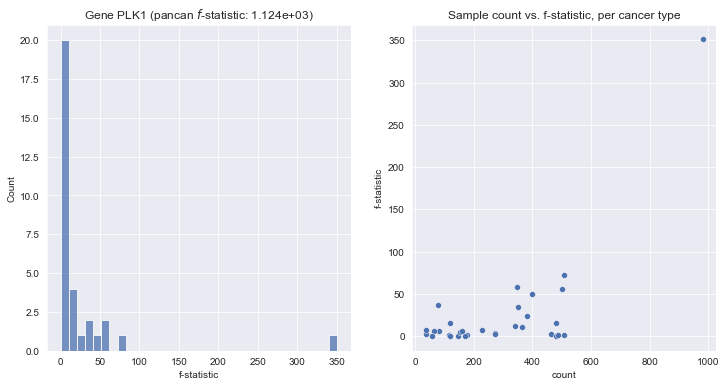

In [24]:
sns.set({'figure.figsize': (12, 6)})

fig, axarr = plt.subplots(1, 2)

sns.histplot(dist_df, ax=axarr[0])
axarr[0].set_xlabel('f-statistic')
axarr[0].set_title(r'Gene {} (pancan $f$-statistic: {:.3e})'.format(
    entrez_to_symbol[int(plot_gene)],
    f_stats_df.loc[plot_gene, 'pancan']))

sns.scatterplot(data=f_ss_df, x='count', y='f_statistic', ax=axarr[1])
axarr[1].set_ylabel('f-statistic')
axarr[1].set_title('Sample count vs. f-statistic, per cancer type')

In [25]:
# this is an example of less skewed distribution
# (the cancer type with the top f-statistic, BRCA, has a much smaller LOF)
plot_gene = sorted_genes[18]
dist_df, f_ss_df = plot_f_dist(plot_gene)
f_ss_df.sort_values(by='f_statistic', ascending=False).head(10)

,f_statistic,count
BRCA,64.070699,981
UCEC,46.365732,507
LGG,32.065341,507
LUAD,21.327605,502
BLCA,17.633666,398
COAD,9.232498,341
OV,8.320908,176
PRAD,7.205094,479
STAD,6.219720,383
KIRC,4.241350,352


Text(0.5, 1.0, 'Sample count vs. f-statistic, per cancer type')

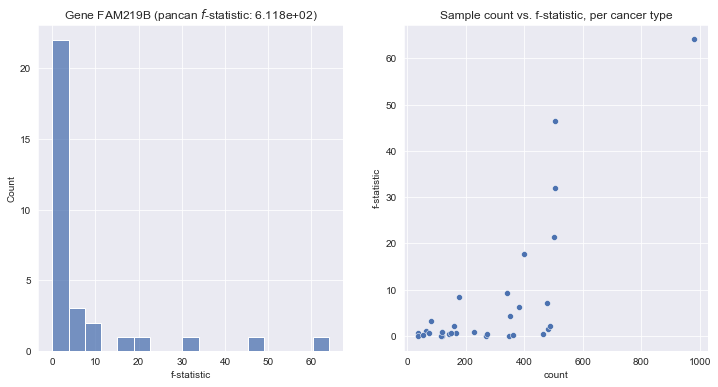

In [26]:
sns.set({'figure.figsize': (12, 6)})

fig, axarr = plt.subplots(1, 2)

sns.histplot(dist_df, ax=axarr[0])
axarr[0].set_xlabel('f-statistic')
axarr[0].set_title(r'Gene {} (pancan $f$-statistic: {:.3e})'.format(
    entrez_to_symbol[int(plot_gene)],
    f_stats_df.loc[plot_gene, 'pancan']))

sns.scatterplot(data=f_ss_df, x='count', y='f_statistic', ax=axarr[1])
axarr[1].set_ylabel('f-statistic')
axarr[1].set_title('Sample count vs. f-statistic, per cancer type')

In the plots above, each point is a cancer type. The left plot shows the distribution of f-statistics (higher = better correlation with labels) across cancer types, and the right plot shows f-statistic vs. sample size.

For TP53, we can see that there might be a slight correlation with sample size (BRCA, the largest/best sampled cancer type, tends to have higher f-statistics for most genes) but this isn't necessarily the case for other genes. It's possible/likely that expression is generally just very predictive of TP53 mutation status in many genes.

In [27]:
# save univariate correlation results
output_dir = cfg.data_dir / 'univariate_corrs'
output_dir.mkdir(exist_ok=True)

output_file = output_dir / '{}_{}_corrs.tsv'.format(gene, mad_threshold)
rank_df.to_csv(output_file, sep='\t')